In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None



In [3]:
aloha = pd.read_csv('results/aloha.csv', converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray})


In [4]:
aloha.head()


run     type module name  \
0  MAM10-BMRELAY-2-20200910-01:29:21-78632  runattr    NaN  NaN   
1  MAM10-BMRELAY-2-20200910-01:29:21-78632  runattr    NaN  NaN   
2  MAM10-BMRELAY-2-20200910-01:29:21-78632  runattr    NaN  NaN   
3  MAM10-BMRELAY-2-20200910-01:29:21-78632  runattr    NaN  NaN   
4  MAM10-BMRELAY-2-20200910-01:29:21-78632  runattr    NaN  NaN   

        attrname               attrvalue  value  count  sumweights  mean  \
0     configname           MAM10-BMRELAY    NaN    NaN         NaN   NaN   
1       datetime       20200910-01:29:21    NaN    NaN         NaN   NaN   
2     experiment           MAM10-BMRELAY    NaN    NaN         NaN   NaN   
3        inifile             omnetpp.ini    NaN    NaN         NaN   NaN   
4  iterationvars  $delta=0, $speedMps=14    NaN    NaN         NaN   NaN   

   stddev  min  max binedges binvalues  
0     NaN  NaN  NaN     None      None  
1     NaN  NaN  NaN     None      None  
2     NaN  NaN  NaN     None      None  
3     NaN  NaN  NaN     None      None  
4     NaN  NaN  NaN     None      None

In [5]:
allAttrs = aloha[(aloha.type == 'itervar')]['attrname'].unique()
allAttrs.sort()
allAttrs

array(['delta', 'speedMps'], dtype=object)

In [6]:
allRelayModes = aloha[(aloha['attrname'].str.contains('.app[0].relayMode', na=False, regex=False))]['attrvalue'].unique()
allRelayModes.sort()
allRelayModes

array(['"BMesh"', '"MAM"'], dtype=object)

In [7]:
allSpeeds = aloha[(aloha.attrname == 'speedMps')]['attrvalue'].unique()
allSpeeds.sort()
allSpeeds

array([2.0, 6.0, 14.0], dtype=object)

In [8]:
allDeltas = aloha[(aloha.attrname == 'delta')]['attrvalue'].unique()
allDeltas.sort()
allDeltas = allDeltas[1:]
allDeltas

array([2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 500.0, 1000.0, 5000.0, 10000.0,
       15000.0, 20000.0], dtype=object)

In [9]:
dataByRun = aloha.groupby(['run'])
dataByRun.size()

run
MAM10-BMRELAY-0-20200910-01:29:13-78632      2521
MAM10-BMRELAY-1-20200910-01:29:18-78632      2521
MAM10-BMRELAY-2-20200910-01:29:21-78632      2521
MAM10-MAMRELAY-0-20200910-01:29:23-78642     2521
MAM10-MAMRELAY-1-20200910-01:29:28-78642     2521
                                            ...  
MAM50-MAMRELAY-5-20200910-01:02:26-77708    11483
MAM50-MAMRELAY-6-20200910-01:02:48-77708    11483
MAM50-MAMRELAY-7-20200910-01:03:38-77708    11483
MAM50-MAMRELAY-8-20200910-01:04:30-77708    11483
MAM50-MAMRELAY-9-20200910-01:04:56-77708    11483
Length: 114, dtype: int64

In [10]:

def findBluetoothRelayRun(speed, configName):
    def testA(x):
        bmeshMatch = x[(x['attrname'].str.contains('.app[0].relayMode', na=False, regex=False))]['attrvalue'].iloc[0] == '"BMesh"'
        speedMatch = x[(x.attrname == 'speedMps')]['attrvalue'].iloc[0] == speed
        configNameMatch = x[(x.attrname == 'configname')]['attrvalue'].iloc[0] == configName
    
        return bmeshMatch & speedMatch & configNameMatch

    s = pd.Series(dataByRun.apply(testA))
    s = s[s == True]
    if len(s) == 0:
        raise Exception("Bluetooth Relay run not found for speed=" + str(speed) + " configName=" + configName)
    if len(s) > 1:
        raise Exception("Bluetooth Relay run duplicate for speed=" + str(speed) + " configName=" + configName)
    return s.index[0]

findBluetoothRelayRun(speed=6, configName='MAM10-BMRELAY')



'MAM10-BMRELAY-1-20200910-01:29:18-78632'

In [11]:

def findMAMRelayRun(speed, delta, configName):
    def testA(x):
        bmeshMatch = x[(x['attrname'].str.contains('.app[0].relayMode', na=False, regex=False))]['attrvalue'].iloc[0] == '"MAM"'
        speedMatch = x[(x.attrname == 'speedMps')]['attrvalue'].iloc[0] == speed
        deltaMatch = x[(x.attrname == 'delta')]['attrvalue'].iloc[0] == delta
        configNameMatch = x[(x.attrname == 'configname')]['attrvalue'].iloc[0] == configName
    
        return bmeshMatch & speedMatch & deltaMatch & configNameMatch

    s = pd.Series(dataByRun.apply(testA))
    s = s[s == True]
    if len(s) == 0:
        raise Exception("MAM Relay run not found for speed=" + str(speed) + " delta=" + str(delta) + " configName=" + configName)
    if len(s) > 1:
        raise Exception("MAM Relay run duplicate for speed=" + str(speed) + " delta=" + str(delta) + " configName=" + configName)
    return s.index[0]

findMAMRelayRun(speed=2, delta=5, configName='MAM50-MAMRELAY')


'MAM50-MAMRELAY-3-20200910-01:00:54-77708'

In [12]:
def getRunData(run):
    return aloha[aloha.run == run]

def getCollectorRunScalars(run):
    runData = aloha[aloha.run == run]
    runData = runData[(runData.type=='scalar')]
    return runData[runData['module'].str.contains('collector1.app')]

getRunData(findBluetoothRelayRun(speed=6, configName='MAM10-BMRELAY'))

run       type  \
237     MAM10-BMRELAY-1-20200910-01:29:18-78632    runattr   
238     MAM10-BMRELAY-1-20200910-01:29:18-78632    runattr   
239     MAM10-BMRELAY-1-20200910-01:29:18-78632    runattr   
240     MAM10-BMRELAY-1-20200910-01:29:18-78632    runattr   
241     MAM10-BMRELAY-1-20200910-01:29:18-78632    runattr   
...                                         ...        ...   
541924  MAM10-BMRELAY-1-20200910-01:29:18-78632  histogram   
541925  MAM10-BMRELAY-1-20200910-01:29:18-78632       attr   
541926  MAM10-BMRELAY-1-20200910-01:29:18-78632       attr   
541927  MAM10-BMRELAY-1-20200910-01:29:18-78632       attr   
541928  MAM10-BMRELAY-1-20200910-01:29:18-78632       attr   

                         module                     name           attrname  \
237                         NaN                      NaN         configname   
238                         NaN                      NaN           datetime   
239                         NaN                      NaN         experiment   
240                         NaN                      NaN            inifile   
241                         NaN                      NaN      iterationvars   
...                         ...                      ...                ...   
541924  MAM10.collector1.app[0]  endToEndDelay:histogram                NaN   
541925  MAM10.collector1.app[0]  endToEndDelay:histogram  interpolationmode   
541926  MAM10.collector1.app[0]  endToEndDelay:histogram             source   
541927  MAM10.collector1.app[0]  endToEndDelay:histogram              title   
541928  MAM10.collector1.app[0]  endToEndDelay:histogram               unit   

                          attrvalue  value   count  sumweights      mean  \
237                   MAM10-BMRELAY    NaN     NaN         NaN       NaN   
238               20200910-01:29:18    NaN     NaN         NaN       NaN   
239                   MAM10-BMRELAY    NaN     NaN         NaN       NaN   
240                     omnetpp.ini    NaN     NaN         NaN       NaN   
241           $delta=0, $speedMps=6    NaN     NaN         NaN       NaN   
...                             ...    ...     ...         ...       ...   
541924                         None    NaN  2663.0         NaN  0.021299   
541925                         none    NaN     NaN         NaN       NaN   
541926      dataAge(packetReceived)    NaN     NaN         NaN       NaN   
541927  end-to-end delay, histogram    NaN     NaN         NaN       NaN   
541928                            s    NaN     NaN         NaN       NaN   

          stddev  min       max  \
237          NaN  NaN       NaN   
238          NaN  NaN       NaN   
239          NaN  NaN       NaN   
240          NaN  NaN       NaN   
241          NaN  NaN       NaN   
...          ...  ...       ...   
541924  0.017529  0.0  0.088385   
541925       NaN  NaN       NaN   
541926       NaN  NaN       NaN   
541927       NaN  NaN       NaN   
541928       NaN  NaN       NaN   

                                                 binedges  \
237                                                  None   
238                                                  None   
239                                                  None   
240                                                  None   
241                                                  None   
...                                                   ...   
541924  [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006...   
541925                                               None   
541926                                               None   
541927                                               None   
541928                                               None   

                                                binvalues  
237                                                  None  
238                                                  None  
239                                                  None  
240                                        

In [13]:
aloha.iloc[1200:1205]


run     type module name  \
1200  MAM10-MAMRELAY-7-20200910-01:29:48-78642  itervar    NaN  NaN   
1201  MAM10-MAMRELAY-7-20200910-01:29:48-78642    param    NaN  NaN   
1202  MAM10-MAMRELAY-7-20200910-01:29:48-78642    param    NaN  NaN   
1203  MAM10-MAMRELAY-7-20200910-01:29:48-78642    param    NaN  NaN   
1204  MAM10-MAMRELAY-7-20200910-01:29:48-78642    param    NaN  NaN   

                         attrname attrvalue  value  count  sumweights  mean  \
1200                     speedMps         6    NaN    NaN         NaN   NaN   
1201     *.host*.app[0].relayMode     "MAM"    NaN    NaN         NaN   NaN   
1202         *.host*.app[0].delta        10    NaN    NaN         NaN   NaN   
1203  *.collector*.mobility.speed      6mps    NaN    NaN         NaN   NaN   
1204     *.host*.app[0].relayMode   "BMesh"    NaN    NaN         NaN   NaN   

      stddev  min  max binedges binvalues  
1200     NaN  NaN  NaN     None      None  
1201     NaN  NaN  NaN     None      None  
1202     NaN  NaN  NaN     None      None  
1203     NaN  NaN  NaN     None      None  
1204     NaN  NaN  NaN     None      None

In [14]:
aloha.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572400 entries, 0 to 572399
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   run         572400 non-null  object 
 1   type        572400 non-null  object 
 2   module      563316 non-null  object 
 3   name        563316 non-null  object 
 4   attrname    400746 non-null  object 
 5   attrvalue   400746 non-null  object 
 6   value       159024 non-null  float64
 7   count       12630 non-null   float64
 8   sumweights  0 non-null       float64
 9   mean        7692 non-null    float64
 10  stddev      7692 non-null    float64
 11  min         7692 non-null    float64
 12  max         7692 non-null    float64
 13  binedges    10218 non-null   object 
 14  binvalues   10218 non-null   object 
dtypes: float64(7), object(8)
memory usage: 65.5+ MB


In [15]:
aloha.describe()

value         count  sumweights         mean       stddev  \
count  1.590240e+05  12630.000000         0.0  7692.000000  7692.000000   
mean   6.411322e+03   1608.503642         NaN    13.498123    37.131905   
std    1.406781e+05   2241.346223         NaN    65.110243   297.771770   
min   -1.320731e+00      0.000000         NaN     0.000000     0.000000   
25%    0.000000e+00      0.000000         NaN     0.001577     0.009655   
50%    0.000000e+00    565.500000         NaN     0.044375     0.187981   
75%    3.740000e+02   2500.000000         NaN     8.187670     6.933193   
max    9.870611e+06  14082.000000         NaN  1081.479510  7633.692200   

                 min           max  
count   7.692000e+03   7692.000000  
mean    3.705519e-01    427.355448  
std     1.484804e+00   4282.848525  
min     0.000000e+00      0.000000  
25%     0.000000e+00      0.148807  
50%    5.272336e-215      1.000000  
75%     1.553998e-01     35.640248  
max     1.838884e+01  79967.906778

In [16]:
scalars = aloha[(aloha.type=='scalar')]
scalars.head()


run    type  \
9084  MAM10-BMRELAY-2-20200910-01:29:21-78632  scalar   
9085  MAM10-BMRELAY-2-20200910-01:29:21-78632  scalar   
9086  MAM10-BMRELAY-2-20200910-01:29:21-78632  scalar   
9087  MAM10-BMRELAY-2-20200910-01:29:21-78632  scalar   
9088  MAM10-BMRELAY-2-20200910-01:29:21-78632  scalar   

                             module                            name attrname  \
9084  MAM10.radioMedium.propagation       Arrival computation count      NaN   
9085              MAM10.radioMedium              transmission count      NaN   
9086              MAM10.radioMedium               signal send count      NaN   
9087              MAM10.radioMedium     reception computation count      NaN   
9088              MAM10.radioMedium  interference computation count      NaN   

     attrvalue     value  count  sumweights  mean  stddev  min  max binedges  \
9084      None   52840.0    NaN         NaN   NaN     NaN  NaN  NaN     None   
9085      None    5284.0    NaN         NaN   NaN     NaN  NaN  NaN     None   
9086      None   52840.0    NaN         NaN   NaN     NaN  NaN  NaN     None   
9087      None   52840.0    NaN         NaN   NaN     NaN  NaN  NaN     None   
9088      None  134479.0    NaN         NaN   NaN     NaN  NaN  NaN     None   

     binvalues  
9084      None  
9085      None  
9086      None  
9087      None  
9088      None

In [17]:
runPrefix = 'MAM50-BMRELAY-0'
run2Prefix = 'MAM50-MAMRELAY-6'

In [18]:
def getScalarSum(scalarName, runData):
    scalarData = runData[(runData.type=='scalar')]
    return scalarData[(scalarData.name==scalarName)]['value'].sum()

energyConsumptionSum = getScalarSum(scalarName='residualEnergyCapacity:last', 
                        runData=getRunData(findBluetoothRelayRun(speed=2, configName='MAM50-BMRELAY')))
energyConsumptionSum

-27.004494456353694

In [19]:
energyConsumption2Sum = getScalarSum(scalarName='residualEnergyCapacity:last', 
                        runData=getRunData(findMAMRelayRun(speed=2, delta=10, configName='MAM50-MAMRELAY')))
energyConsumption2Sum

-26.462930404682904

In [20]:
def getUniqueScalarValue(scalarName, scalarData):
    scalarValue = scalarData[(scalarData.name==scalarName)]['value']

    if len(scalarValue) > 1:
        raise Exception('Scalar ' + scalarName + ' is not unique on this dataframe')
    return scalarValue.iloc[0]

collectorPacketsReceived = getUniqueScalarValue(scalarName='packetReceived:count', 
                        scalarData=getCollectorRunScalars(findBluetoothRelayRun(speed=2, configName='MAM50-BMRELAY')))

'Packets received (BM 2): ' + str(collectorPacketsReceived)

'Packets received (BM 2): 2161.0'

In [21]:
collectorPacketsReceived2 = getUniqueScalarValue(scalarName='packetReceived:count', 
                        scalarData=getCollectorRunScalars(findMAMRelayRun(speed=2, delta=10, configName='MAM50-MAMRELAY')))

'Packets received (MAM 2 D5): ' + str(collectorPacketsReceived2)

'Packets received (MAM 2 D5): 2401.0'

In [22]:
dataPacketsSent = getScalarSum('data packets sent', getRunData(findBluetoothRelayRun(speed=2, configName='MAM50-BMRELAY')))
dataPacketsSent2 = getScalarSum('data packets sent', getRunData(findMAMRelayRun(speed=2, delta=10, configName='MAM50-MAMRELAY')))

'Data packets sent (BM 2): ' + str(dataPacketsSent) + ' / Data packets sent (MAM 2 D5): ' + str(dataPacketsSent2)

'Data packets sent (BM 2): 28387.0 / Data packets sent (MAM 2 D5): 12979.0'

In [23]:
def getHistogramData(histogramName, runData):
    histograms = runData[runData.type == 'histogram']
    histogram = histograms[histograms.name == histogramName]
    if len(histogram) == 0:
        raise Exception('Histogram not found')
    if len(histogram) > 1:
        raise Exception('Histogram match not unique')
    return histogram.iloc[0]

hist = getHistogramData(histogramName='endToEndDelay:histogram', 
                        runData=getRunData(findBluetoothRelayRun(speed=2, configName='MAM50-BMRELAY')))
hist

run                     MAM50-BMRELAY-0-20200910-00:57:17-77675
type                                                  histogram
module                                  MAM50.collector1.app[0]
name                                    endToEndDelay:histogram
attrname                                                    NaN
attrvalue                                                  None
value                                                       NaN
count                                                      2161
sumweights                                                  NaN
mean                                                  0.0314659
stddev                                                0.0275305
min                                                           0
max                                                    0.155902
binedges      [0.0, 0.002, 0.004, 0.006, 0.008, 0.01, 0.012,...
binvalues     [228.0, 181.0, 84.0, 77.0, 72.0, 65.0, 46.0, 4...
Name: 549086, dtype: object

In [24]:
hist2 = getHistogramData(histogramName='endToEndDelay:histogram', 
                        runData=getRunData(findMAMRelayRun(speed=2, delta=10, configName='MAM50-MAMRELAY')))
hist2

run                    MAM50-MAMRELAY-6-20200910-01:02:48-77708
type                                                  histogram
module                                  MAM50.collector1.app[0]
name                                    endToEndDelay:histogram
attrname                                                    NaN
attrvalue                                                  None
value                                                       NaN
count                                                      2401
sumweights                                                  NaN
mean                                                  0.0636499
stddev                                                0.0624063
min                                                           0
max                                                    0.347691
binedges      [0.0, 0.004, 0.008, 0.012, 0.016, 0.02, 0.024,...
binvalues     [387.0, 114.0, 86.0, 77.0, 70.0, 72.0, 67.0, 8...
Name: 556490, dtype: object

In [25]:
hist2.binedges, hist2.binvalues

(array([0.   , 0.004, 0.008, 0.012, 0.016, 0.02 , 0.024, 0.028, 0.032,
        0.036, 0.04 , 0.044, 0.048, 0.052, 0.056, 0.06 , 0.064, 0.068,
        0.072, 0.076, 0.08 , 0.084, 0.088, 0.092, 0.096, 0.1  , 0.104,
        0.108, 0.112, 0.116, 0.12 , 0.124, 0.128, 0.132, 0.136, 0.14 ,
        0.144, 0.148, 0.152, 0.156, 0.16 , 0.164, 0.168, 0.172, 0.176,
        0.18 , 0.184, 0.188, 0.192, 0.196, 0.2  , 0.204, 0.208, 0.212,
        0.216, 0.22 , 0.224, 0.228, 0.232, 0.236, 0.24 , 0.244, 0.248,
        0.252, 0.256, 0.26 , 0.264, 0.268, 0.272, 0.276, 0.28 , 0.284,
        0.288, 0.292, 0.296, 0.3  , 0.304, 0.308, 0.312, 0.316, 0.32 ,
        0.324, 0.328, 0.332, 0.336, 0.34 , 0.344, 0.348]),
 array([387., 114.,  86.,  77.,  70.,  72.,  67.,  87.,  60.,  66.,  77.,
         79.,  55.,  64.,  57.,  58.,  49.,  48.,  47.,  43.,  48.,  47.,
         43.,  36.,  26.,  29.,  13.,  13.,  25.,  20.,  23.,  36.,  20.,
         19.,  14.,  15.,  12.,  21.,  25.,  18.,  21.,  14.,  17.,   9.,
      

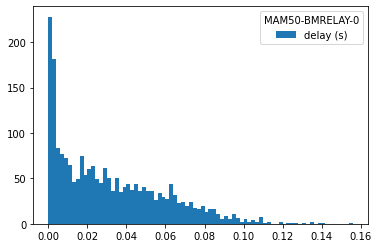

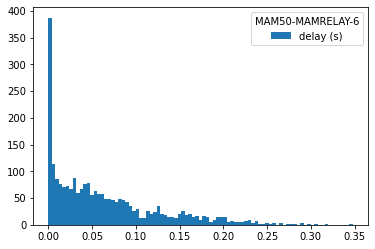

In [26]:

plt.hist(bins=hist.binedges, x=hist.binedges[:-1], weights=hist.binvalues, label="delay (s)")
plt.legend(title=runPrefix)
plt.show()

plt.hist(bins=hist2.binedges, x=hist2.binedges[:-1], weights=hist2.binvalues, label="delay (s)")
plt.legend(title=run2Prefix)
plt.show()

In [27]:
str(100-energyConsumption2Sum/energyConsumptionSum*100) + '% ' + run2Prefix + ' energy efficiency compared to ' + runPrefix

'2.005458952568432% MAM50-MAMRELAY-6 energy efficiency compared to MAM50-BMRELAY-0'

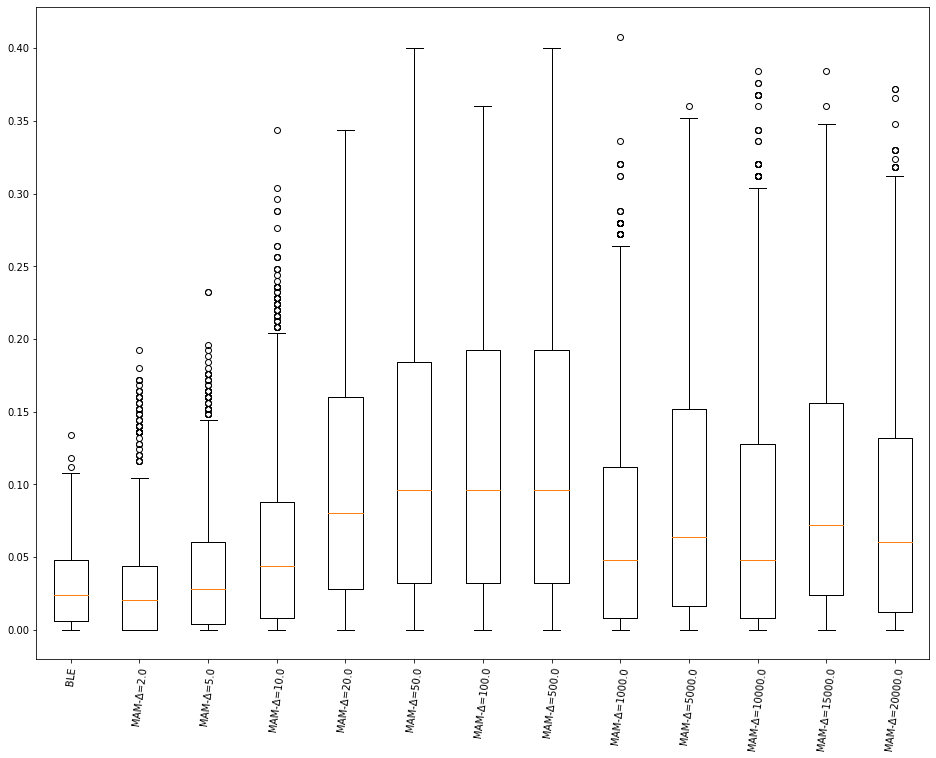

In [65]:
def explodeHistogramData(histogram):
    a = []

    i = 0
    for aa in histogram.binedges[:-1]:
        for j in range(1,histogram.binvalues[i].astype(np.int)):
            a.append(aa)
        i = i + 1
    return a

# Create a figure instance
fig = plt.figure(1, figsize=(16, 12))

# Create an axes instance
ax = fig.add_subplot(111)

bmesh2mpsData = explodeHistogramData(getHistogramData(histogramName='endToEndDelay:histogram', 
                        runData=getRunData(findBluetoothRelayRun(speed=2, configName='MAM50-BMRELAY'))))
    
data_to_plot_2ms = [bmesh2mpsData]
labels = ['BLE']

for d in allDeltas:
    data_to_plot_2ms.append(explodeHistogramData(getHistogramData(histogramName='endToEndDelay:histogram', 
                        runData=getRunData(findMAMRelayRun(speed=2, delta=d, configName='MAM50-MAMRELAY')))))
    labels.append('MAM-Δ=' + str(d))

# Create the boxplot
bp = ax.boxplot(data_to_plot_2ms)

ax.set_xticklabels(labels)
plt.xticks(rotation='82.5')

# Save the figure
fig.savefig('fig1.png', bbox_inches='tight')

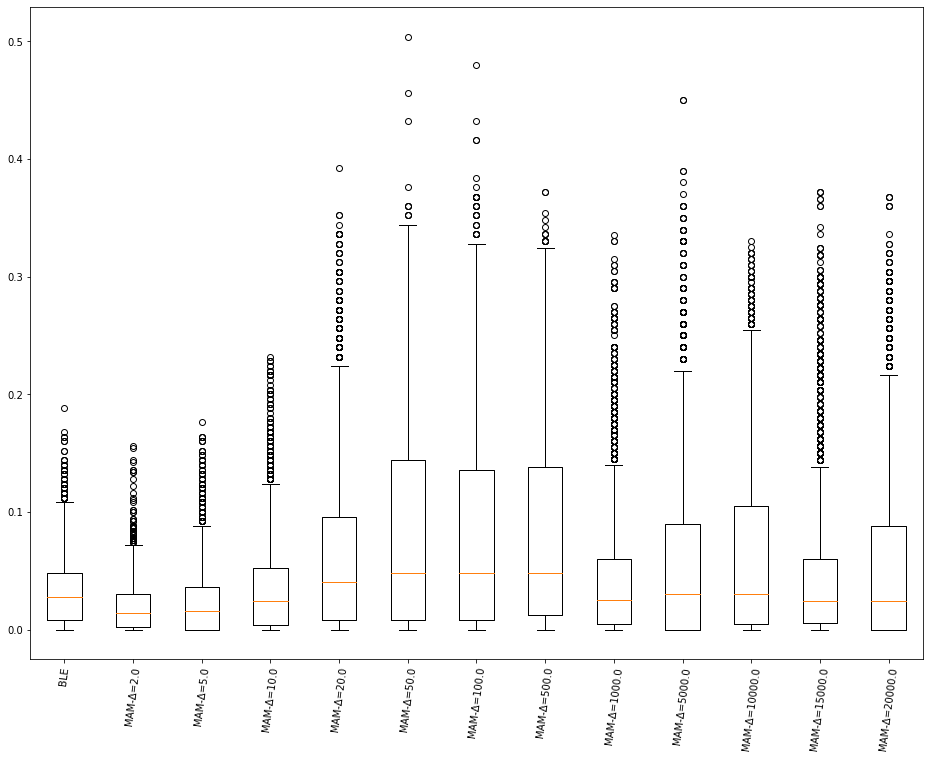

In [64]:
# Create a figure instance
fig = plt.figure(1, figsize=(16, 12))

# Create an axes instance
ax = fig.add_subplot(111)

bmesh6mpsData = explodeHistogramData(getHistogramData(histogramName='endToEndDelay:histogram', 
                        runData=getRunData(findBluetoothRelayRun(speed=6, configName='MAM50-BMRELAY'))))
    
data_to_plot_6ms = [bmesh6mpsData]
labels = ['BLE']

for d in allDeltas:
    data_to_plot_6ms.append(explodeHistogramData(getHistogramData(histogramName='endToEndDelay:histogram', 
                        runData=getRunData(findMAMRelayRun(speed=6, delta=d, configName='MAM50-MAMRELAY')))))
    labels.append('MAM-Δ=' + str(d))

# Create the boxplot
bp = ax.boxplot(data_to_plot_6ms)

ax.set_xticklabels(labels)
plt.xticks(rotation='82.5')

# Save the figure
fig.savefig('fig2.png', bbox_inches='tight')

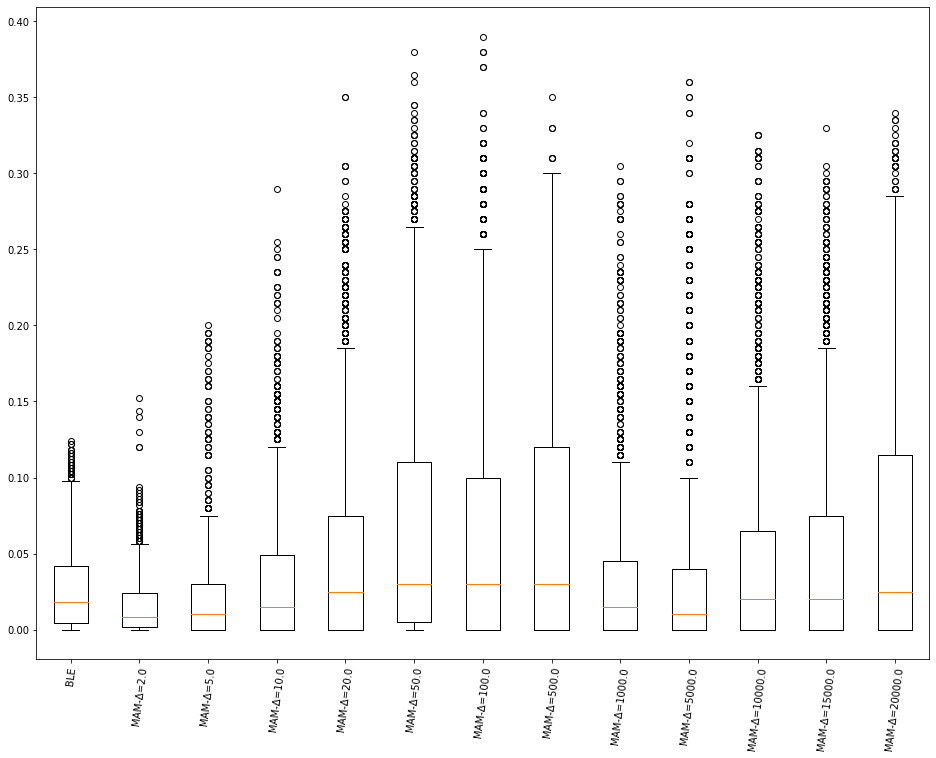

In [63]:
# Create a figure instance
fig = plt.figure(1, figsize=(16, 12))

# Create an axes instance
ax = fig.add_subplot(111)

bmesh14mpsData = explodeHistogramData(getHistogramData(histogramName='endToEndDelay:histogram', 
                        runData=getRunData(findBluetoothRelayRun(speed=14, configName='MAM50-BMRELAY'))))
    
data_to_plot_14ms = [bmesh14mpsData]
labels = ['BLE']

for d in allDeltas:
    data_to_plot_14ms.append(explodeHistogramData(getHistogramData(histogramName='endToEndDelay:histogram', 
                        runData=getRunData(findMAMRelayRun(speed=14, delta=d, configName='MAM50-MAMRELAY')))))
    labels.append('MAM-Δ=' + str(d))

# Create the boxplot
bp = ax.boxplot(data_to_plot_14ms)

ax.set_xticklabels(labels)
plt.xticks(rotation='82.5')

# Save the figure
fig.savefig('fig3.png', bbox_inches='tight')

In [32]:
#TODO mhub data received bar chart. energy draw bar chart.

In [57]:
def getEnergyConsumptionData(speed):
    energyConsumptionSumBM = getScalarSum(scalarName='residualEnergyCapacity:last', 
                            runData=getRunData(findBluetoothRelayRun(speed=speed, configName='MAM50-BMRELAY')))


    labels = ['BM']
    values = [-energyConsumptionSum]

    for d in allDeltas:
        values.append(-getScalarSum(scalarName='residualEnergyCapacity:last', 
                            runData=getRunData(findMAMRelayRun(speed=speed, delta=d, configName='MAM50-MAMRELAY'))))
        labels.append('MAM-Δ=' + str(d))
    return [labels, values]

[labels, values] = getEnergyConsumptionData(2)

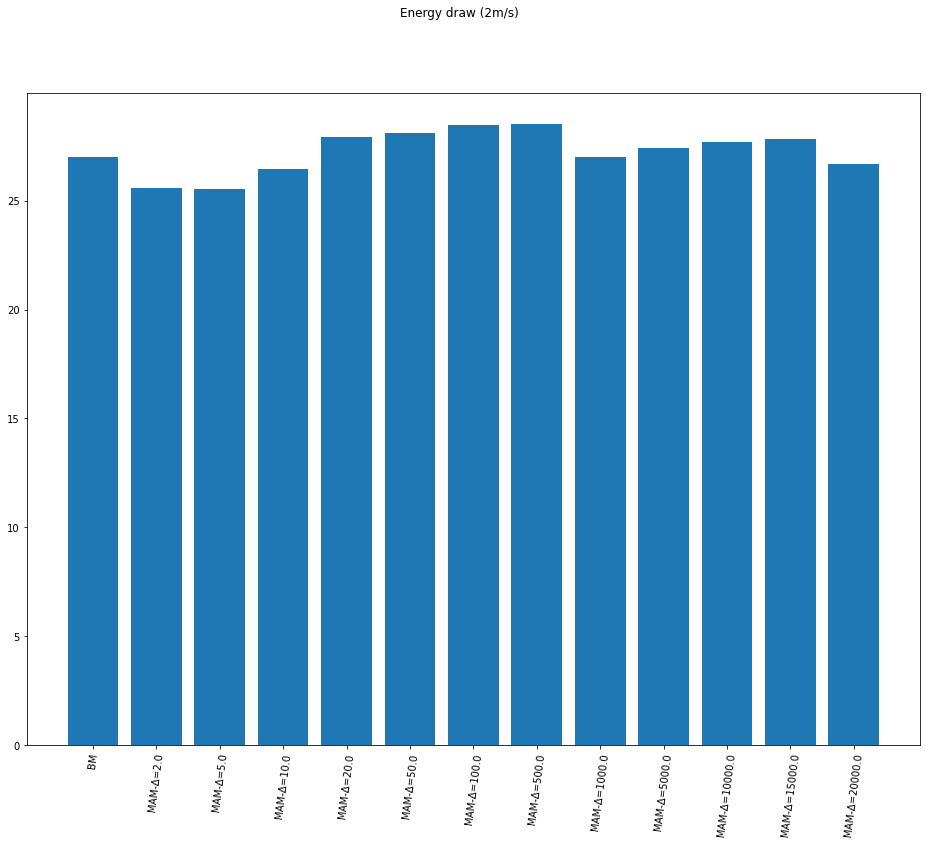

In [59]:
def plotEnergyConsumptionData(labels, values, speed, imageIdx):
    # Create a figure instance
    fig = plt.figure(1, figsize=(16, 12))

    # Create an axes instance
    ax = fig.add_subplot(111)

    # Create the barchart
    bp = ax.bar(labels, values)

    plt.suptitle('Energy draw (' + str(speed) + 'm/s)')
    plt.xticks(rotation='82.5')

    # Save the figure
    fig.savefig('fig' + str(imageIdx) + '.png', bbox_inches='tight')
    
plotEnergyConsumptionData(labels, values, 2, 4)

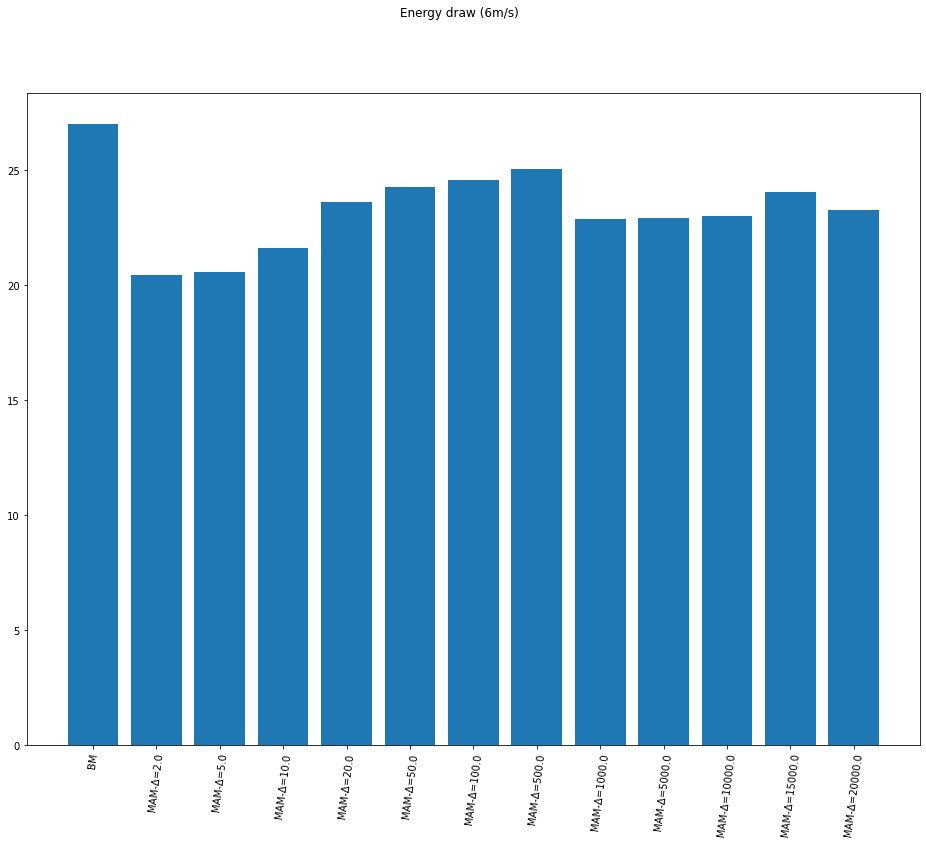

In [60]:
[labels, values] = getEnergyConsumptionData(6)
plotEnergyConsumptionData(labels, values, 6, 5)

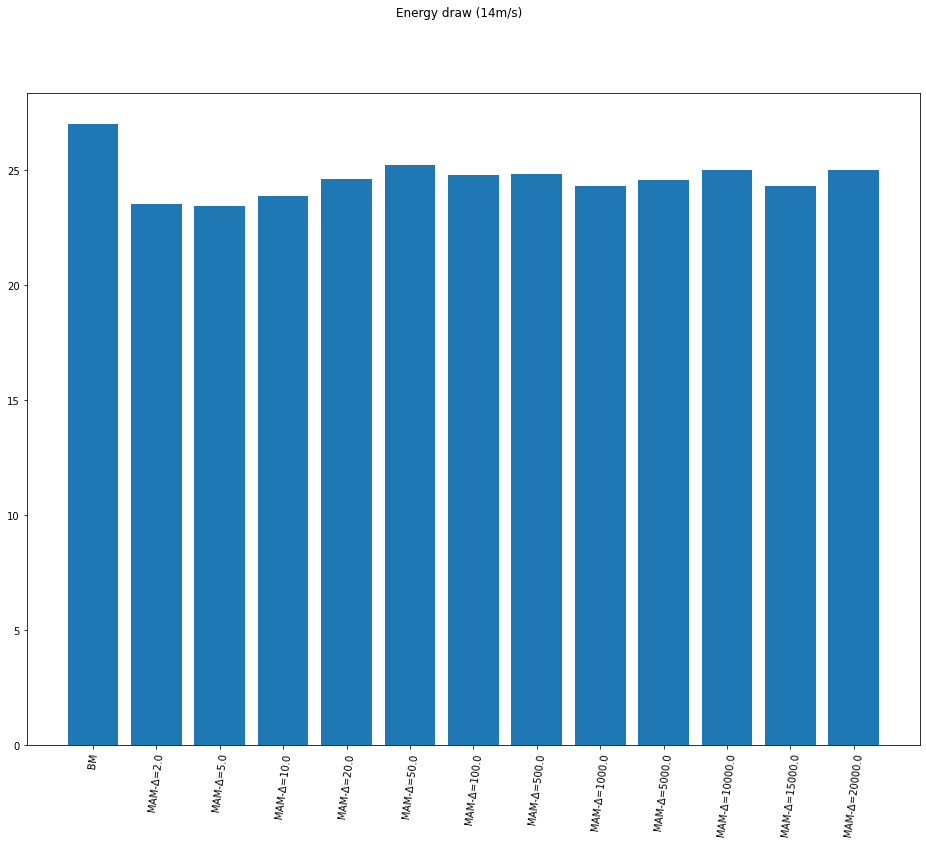

In [62]:
[labels, values] = getEnergyConsumptionData(14)
plotEnergyConsumptionData(labels, values, 14, 6)